# Glmnet Vignette (for python)
#### Trevor Hastie and B. J. Balakumar (Stanford University)

<a id='toc'></a>
# Table of Contents

<a href='#linearRegression'>Linear Regression</a> <br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href='#gaussian'>Gaussian family</a> <br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href='#mgaussian'>Multiresponse Gaussian Family</a><br>
<a href='#logisticRegression'>Logistic Regression</a> <br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href='#binomial'>Binomial Models</a> <br>
&nbsp;&nbsp;&nbsp;&nbsp;<a href='#multinomial'>Multinomial Models</a><br>
<a href='#poisson'>Poisson Models</a> <br>
<a href='#cox'>Cox Models</a> <br><br>
<a href='#references'>References</a>

<a id='linearRegression'></a>
# Linear Regression
Linear regression here refers to two families of models. One is `gaussian`, the Gaussian family, and the other is `mgaussian`, the multiresponse Gaussian family. We first discuss the ordinary Gaussian and the multiresponse one after that.

<a id='gaussian'></a>
## Linear Regression: Gaussian family

`gaussian ` is the default family option in the function `glmnet`. Suppose we have observations $x_i \in \mathbb{R}^p$ and the responses $y_i \in \mathbb{R}, i = 1, \ldots, N$. The objective function for the Gaussian family is
$$
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}}\frac{1}{2N} \sum_{i=1}^N (y_i -\beta_0-x_i^T \beta)^2+\lambda \left[ (1-\alpha)||\beta||_2^2/2 + \alpha||\beta||_1\right],
$$
where $\lambda \geq 0$ is a complexity parameter and $0 \leq \alpha \leq 1$ is a compromise between ridge ($\alpha = 0$) and lasso ($\alpha = 1$).

Coordinate descent is applied to solve the problem. Specifically, suppose we have current estimates $\tilde{\beta_0}$ and $\tilde{\beta}_\ell$ $\forall j\in 1,\ldots,p$. By computing the gradient at $\beta_j = \tilde{\beta}_j$ and simple calculus, the update is
$$
\tilde{\beta}_j \leftarrow \frac{S(\frac{1}{N}\sum_{i=1}^N x_{ij}(y_i-\tilde{y}_i^{(j)}),\lambda \alpha)}{1+\lambda(1-\alpha)},
$$
where $\tilde{y}_i^{(j)} = \tilde{\beta}_0 + \sum_{\ell \neq j} x_{i\ell} \tilde{\beta}_\ell$, and $S(z, \gamma)$ is the soft-thresholding operator with value $\text{sign}(z)(|z|-\gamma)_+$.

This formula above applies when the `x` variables are standardized to have unit variance (the default); it is slightly more complicated when they are not. Note that for "family=gaussian", `glmnet` standardizes $y$ to have unit variance before computing its lambda sequence (and then unstandardizes the resulting coefficients); if you wish to reproduce/compare results with other software, best to supply a standardized $y$ first (Using the "1/N" variance formula).

`glmnet` provides various options for users to customize the fit. We introduce some commonly used options here and they can be specified in the `glmnet` function.

* `alpha` is for the elastic-net mixing parameter $\alpha$, with range $\alpha \in [0,1]$. $\alpha = 1$ is the lasso (default) and $\alpha = 0$ is the ridge.

* `weights` is for the observation weights. Default is 1 for each observation. (Note: `glmnet` rescales the weights to sum to N, the sample size.)

* `nlambda` is the number of $\lambda$ values in the sequence. Default is 100.

* `lambda` can be provided, but is typically not and the program constructs a sequence. When automatically generated, the $\lambda$ sequence is determined by `lambda.max` and `lambda.min.ratio`. The latter is the ratio of smallest value of the generated  $\lambda$ sequence (say `lambda.min`) to `lambda.max`.  The program then generated `nlambda` values linear on the log scale from `lambda.max` down to `lambda.min`. `lambda.max` is not given, but easily computed from the input $x$ and $y$; it is the smallest value for `lambda` such that all the coefficients are zero.  For `alpha=0` (ridge) `lambda.max` would be $\infty$; hence for this case we pick a value corresponding to a small value for `alpha` close to zero.)

* `standardize` is a logical flag for `x` variable standardization, prior to fitting the model sequence. The coefficients are always returned on the original scale. Default is `standardize=TRUE`.

For more information, type `help(glmnet)` or simply `?glmnet`. Let us start by loading the data:

In [1]:
# Jupyter setup to expand cell display to 100% width on your screen (optional)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'QuickStartExampleX.dat', dtype = scipy.float64)
y = scipy.loadtxt(baseDataDir + 'QuickStartExampleY.dat', dtype = scipy.float64)

# create weights
t = scipy.ones((50, 1), dtype = scipy.float64)
wts = scipy.row_stack((t, 2*t))

As an example, we set $\alpha = 0.2$ (more like a ridge regression), and give double weights to the latter half of the observations. To avoid too long a display here, we set `nlambda` to 20. In practice, however, the number of values of $\lambda$ is recommended to be 100 (default) or more. In most cases, it does not come with extra cost because of the warm-starts used in the algorithm, and for nonlinear models leads to better convergence properties.

In [3]:
# call glmnet
fit = glmnet(x = x.copy(), y = y.copy(), family = 'gaussian', \
                    weights = wts, \
                    alpha = 0.2, nlambda = 20
                    )

We can then print the `glmnet` object.

In [4]:
glmnetPrint(fit)

	 df 	 %dev 	 lambdau

0 	 0.000000 	 0.000000 	 7.939020
1 	 4.000000 	 0.178852 	 4.889231
2 	 7.000000 	 0.444488 	 3.011024
3 	 7.000000 	 0.656716 	 1.854334
4 	 8.000000 	 0.784984 	 1.141988
5 	 9.000000 	 0.853935 	 0.703291
6 	 10.000000 	 0.886693 	 0.433121
7 	 11.000000 	 0.902462 	 0.266737
8 	 14.000000 	 0.910135 	 0.164269
9 	 17.000000 	 0.913833 	 0.101165
10 	 17.000000 	 0.915417 	 0.062302
11 	 17.000000 	 0.916037 	 0.038369
12 	 19.000000 	 0.916299 	 0.023629
13 	 20.000000 	 0.916405 	 0.014552
14 	 20.000000 	 0.916447 	 0.008962
15 	 20.000000 	 0.916463 	 0.005519
16 	 20.000000 	 0.916469 	 0.003399


This displays the call that produced the object `fit` and a three-column matrix with columns `Df` (the number of nonzero coefficients), `%dev` (the percent deviance explained) and `Lambda` (the corresponding value of $\lambda$).

(Note that the `digits` option can used to specify significant digits in the printout.)

Here the actual number of $\lambda$'s here is less than specified in the call. The reason lies in the stopping criteria of the algorithm. According to the default internal settings, the computations stop if either the fractional change in deviance down the path is less than $10^{-5}$ or the fraction of explained deviance reaches $0.999$. From the last few lines , we see the fraction of deviance does not change much and therefore the computation ends when meeting the stopping criteria. We can change such internal parameters. For details, see the Appendix section or type `help(glmnet.control)`.

We can plot the fitted object as in the previous section. There are more options in the `plot` function.

Users can decide what is on the X-axis. `xvar` allows three measures: "norm" for the $\ell_1$-norm of the coefficients (default), "lambda" for the log-lambda value and "dev" for %deviance explained.

Users can also label the curves with variable sequence numbers simply by setting `label = TRUE`. Let's plot "fit" against the log-lambda value and with each curve labeled.

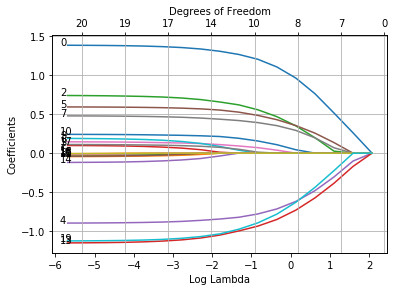

In [5]:
glmnetPlot(fit, xvar = 'lambda', label = True);

Now when we plot against %deviance we get a very different picture. This is percent deviance explained on the training data. What we see here is that toward the end of the path this value are not changing much, but the coefficients are "blowing up" a bit. This lets us focus attention on the parts of the fit that matter. This will especially be true for other models, such as logistic regression.

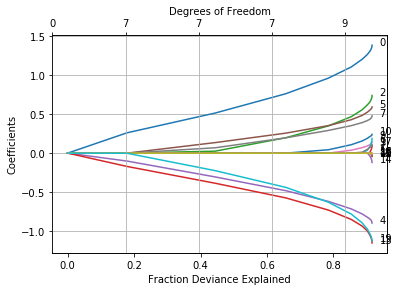

In [6]:
glmnetPlot(fit, xvar = 'dev', label = True);

We can extract the coefficients and make predictions at certain values of $\lambda$. Two commonly used options are:

* `s` specifies the value(s) of $\lambda$ at which extraction is made.

* `exact` indicates whether the exact values of coefficients are desired or not. That is, if `exact = TRUE`, and predictions are to be made at values of s not included in the original fit, these values of s are merged with `object$lambda`, and the model is refit before predictions are made. If `exact=FALSE` (default), then the predict function uses linear interpolation to make predictions for values of s that do not coincide with lambdas used in the fitting algorithm.

A simple example is:

In [7]:
any(fit['lambdau'] == 0.5)

False

In [8]:
glmnetCoef(fit, s = scipy.float64([0.5]), exact = False)

array([[ 0.19909875],
       [ 1.17465045],
       [ 0.        ],
       [ 0.53193465],
       [ 0.        ],
       [-0.76095948],
       [ 0.46820941],
       [ 0.06192676],
       [ 0.38030149],
       [ 0.        ],
       [ 0.        ],
       [ 0.14326099],
       [ 0.        ],
       [ 0.        ],
       [-0.91120737],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.00919663],
       [ 0.        ],
       [-0.86311705]])

The output is for `False`.*(TBD) The exact = 'True' option is not yet implemented*. 

Users can make predictions from the fitted object. In addition to the options in `coef`,  the primary argument is `newx`, a matrix of new values for `x`. The `type` option allows users to choose the type of prediction:
* "link" gives the fitted values

* "response" the sames as "link" for "gaussian" family.

* "coefficients" computes the coefficients at values of `s`

* "nonzero" retuns a list of the indices of the nonzero coefficients for each value of `s`.

For example,


In [9]:
fc = glmnetPredict(fit, x[0:5,:], ptype = 'response', \
                                s = scipy.float64([0.05]))
print(fc)

[[-0.98025907]
 [ 2.29924528]
 [ 0.60108862]
 [ 2.35726679]
 [ 1.75204208]]


gives the fitted values for the first 5 observations at $\lambda = 0.05$. If multiple values of `s` are supplied, a matrix of predictions is produced.

Users can customize K-fold cross-validation. In addition to all the `glmnet` parameters, `cvglmnet` has its special parameters including `nfolds` (the number of folds), `foldid` (user-supplied folds), `ptype`(the loss used for cross-validation):

* "deviance" or "mse" uses squared loss

* "mae" uses mean absolute error

As an example,

In [10]:
warnings.filterwarnings('ignore')  
cvfit = cvglmnet(x = x.copy(), y = y.copy(), ptype = 'mse', nfolds = 20)
warnings.filterwarnings('default')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.128386. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


does 20-fold cross-validation, based on mean squared error criterion (default though).

Parallel computing is also supported by `cvglmnet`. Parallel processing is turned off by default. It can be turned on using `parallel=True` in the `cvglmnet` call. 

Parallel computing can significantly speed up the computation process, especially for large-scale problems. But for smaller problems, it could result in a reduction in speed due to the additional overhead. User discretion is advised.

Functions `coef` and `predict` on cv.glmnet object are similar to those for a `glmnet` object, except that two special strings are also supported by `s` (the values of $\lambda$ requested):

* "lambda.1se": the largest $\lambda$ at which the MSE is within one standard error of the minimal MSE.

* "lambda.min": the $\lambda$ at which the minimal MSE is achieved.

In [11]:
cvfit['lambda_min']

array([ 0.07569327])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.166264. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
cvglmnetCoef(cvfit, s = 'lambda_min')

array([[ 0.14867414],
       [ 1.33377821],
       [ 0.        ],
       [ 0.69787701],
       [ 0.        ],
       [-0.83726751],
       [ 0.54334327],
       [ 0.02668633],
       [ 0.33741131],
       [ 0.        ],
       [ 0.        ],
       [ 0.17105029],
       [ 0.        ],
       [ 0.        ],
       [-1.0755268 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-1.05278699]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.171989. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [13]:
cvglmnetPredict(cvfit, newx = x[0:5,], s='lambda_min')

array([[-1.36388479],
       [ 2.57134278],
       [ 0.57297855],
       [ 1.98814222],
       [ 1.51798822]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.183293. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Users can control the folds used. Here we use the same folds so we can also select a value for $\alpha$.

In [14]:
foldid = scipy.random.choice(10, size = y.shape[0], replace = True)
cv1=cvglmnet(x = x.copy(),y = y.copy(),foldid=foldid,alpha=1)
cv0p5=cvglmnet(x = x.copy(),y = y.copy(),foldid=foldid,alpha=0.5)
cv0=cvglmnet(x = x.copy(),y = y.copy(),foldid=foldid,alpha=0)

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.197048. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


There are no built-in plot functions to put them all on the same plot, so we are on our own here:

../lib/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    

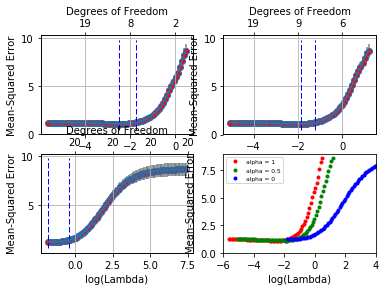

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.259832. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
f = plt.figure()
f.add_subplot(2,2,1)
cvglmnetPlot(cv1)
f.add_subplot(2,2,2)
cvglmnetPlot(cv0p5)
f.add_subplot(2,2,3)
cvglmnetPlot(cv0)
f.add_subplot(2,2,4)
plt.plot( scipy.log(cv1['lambdau']), cv1['cvm'], 'r.')
plt.hold(True)
plt.plot( scipy.log(cv0p5['lambdau']), cv0p5['cvm'], 'g.')
plt.plot( scipy.log(cv0['lambdau']), cv0['cvm'], 'b.')
plt.xlabel('log(Lambda)')
plt.ylabel(cv1['name'])
plt.xlim(-6, 4)
plt.ylim(0, 9)
plt.legend( ('alpha = 1', 'alpha = 0.5', 'alpha = 0'), loc = 'upper left', prop={'size':6});

We see that lasso (`alpha=1`) does about the best here. We also see that the range of lambdas used differs with alpha.

#### Coefficient upper and lower bounds

These are recently added features that enhance the scope of the models. Suppose we want to fit our model, but limit the coefficients to be bigger than -0.7 and less than 0.5. This is easily achieved via the `upper.limits` and `lower.limits` arguments:

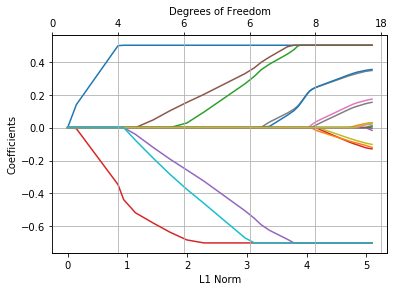

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:22.997428. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
cl = scipy.array([[-0.7], [0.5]], dtype = scipy.float64)
tfit=glmnet(x = x.copy(),y= y.copy(), cl = cl)
glmnetPlot(tfit);

These are rather arbitrary limits; often we want the coefficients to be positive, so we can set only `lower.limit` to be 0.
(Note, the lower limit must be no bigger than zero, and the upper limit no smaller than zero.)
These bounds can be a vector, with different values for each coefficient. If given as a scalar, the same number gets recycled for all.

#### Penalty factors

This argument allows users to apply separate penalty factors to each coefficient. Its default is 1 for each parameter, but other values can be specified. In particular, any variable with `penalty.factor` equal to zero is not penalized at all! Let $v_j$ denote the penalty factor for $j$ th variable. The penalty term becomes
$$
\lambda \sum_{j=1}^p \boldsymbol{v_j} P_\alpha(\beta_j) = \lambda \sum_{j=1}^p \boldsymbol{v_j} \left[ (1-\alpha)\frac{1}{2} \beta_j^2 + \alpha |\beta_j| \right].
$$
Note the penalty factors are internally rescaled to sum to nvars.

This is very useful when people have prior knowledge or preference over the variables. In many cases, some variables may be so important that one wants to keep them all the time, which can be achieved by setting corresponding penalty factors to 0:

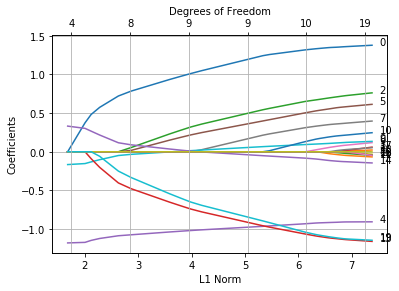

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:23.213373. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
pfac = scipy.ones([1, 20])
pfac[0, 4] = 0; pfac[0, 9] = 0; pfac[0, 14] = 0
pfit = glmnet(x = x.copy(), y = y.copy(), penalty_factor = pfac)
glmnetPlot(pfit, label = True);

We see from the labels that the three variables with 0 penalty factors always stay in the model, while the others follow typical regularization paths and shrunken to 0 eventually.

Some other useful arguments. `exclude` allows one to block certain variables from being the model at all. Of course, one could simply subset these out of `x`, but sometimes `exclude` is more useful, since it returns a full vector of coefficients, just with the excluded ones set to zero. There is also an `intercept` argument which defaults to `True`; if `False` the intercept is forced to be zero.

#### Customizing plots

Sometimes, especially when the number of variables is small, we want to add variable labels to a plot. Since `glmnet` is intended primarily for wide data, this is not supprted in `plot.glmnet`. However, it is easy to do, as the following little toy example shows.

We first generate some data, with 10 variables, and for lack of imagination and ease we give them simple character names. We then fit a glmnet model, and make the standard plot.

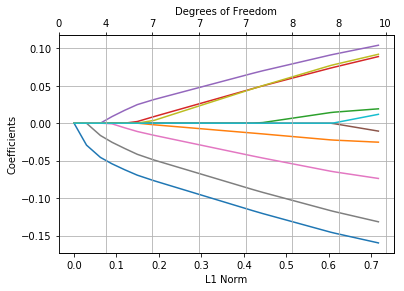

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:23.492432. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
scipy.random.seed(101)
x = scipy.random.rand(100,10)
y = scipy.random.rand(100,1)
fit = glmnet(x = x, y = y)
glmnetPlot(fit);

We wish to label the curves with the variable names. Here's a simple way to do this, using the `matplotlib` library in python (and a little research into how to customize it). We need to have the positions of the coefficients at the end of the path. 

In [19]:
%%capture
# Output from this sample code has been suppressed due to (possible) Jupyter limitations
# The code works just fine from ipython (tested on spyder)
c = glmnetCoef(fit)
c = c[1:, -1] # remove intercept and get the coefficients at the end of the path 
h = glmnetPlot(fit)
ax1 = h['ax1']
xloc = plt.xlim()
xloc = xloc[1]
for i in range(len(c)):
    ax1.text(xloc, c[i], 'var' + str(i));    

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:23.701236. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We have done nothing here to avoid overwriting of labels, in the event that they are close together. This would be a bit more work, but perhaps best left alone, anyway.

[Back to <a href='#toc'>Table of Contents</a>]

<a id='mgaussian'></a>
## Linear Regression: Multiresponse Gaussian Family

The multiresponse Gaussian family is obtained using `family = "mgaussian"` option in `glmnet`. It is very similar to the single-response case above. This is useful when there are a number of (correlated) responses - the so-called "multi-task learning" problem. Here the sharing involves which variables are selected, since when a variable is selected, a coefficient is fit for each response. Most of the options are the same, so we focus here on the differences with the single response model.

Obviously, as the name suggests, $y$ is not a vector, but a matrix of quantitative responses in this section. The coefficients at each value of lambda are also a matrix as a result.

Here we solve the following problem:
$$
\min_{(\beta_0, \beta) \in \mathbb{R}^{(p+1)\times K}}\frac{1}{2N} \sum_{i=1}^N ||y_i -\beta_0-\beta^T x_i||^2_F+\lambda \left[ (1-\alpha)||\beta||_F^2/2 + \alpha\sum_{j=1}^p||\beta_j||_2\right].
$$
Here $\beta_j$ is the jth row of the $p\times K$ coefficient matrix $\beta$, and we replace the absolute penalty on each single coefficient by a group-lasso penalty on each coefficient K-vector $\beta_j$ for a single predictor $x_j$.

We use a set of data generated beforehand for illustration.

In [20]:
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'MultiGaussianExampleX.dat', dtype = scipy.float64, delimiter = ',')
y = scipy.loadtxt(baseDataDir + 'MultiGaussianExampleY.dat', dtype = scipy.float64, delimiter = ',')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.031708. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We fit the data, with an object "mfit" returned.

In [21]:
mfit = glmnet(x = x.copy(), y = y.copy(), family = 'mgaussian')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.130115. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


For multiresponse Gaussian, the options in `glmnet` are almost the same as the single-response case, such as `alpha`, `weights`, `nlambda`, `standardize`. A exception to be noticed is that `standardize.response` is only for `mgaussian` family. The default value is `FALSE`. If `standardize.response = TRUE`, it standardizes the response variables.

To visualize the coefficients, we use the `plot` function.

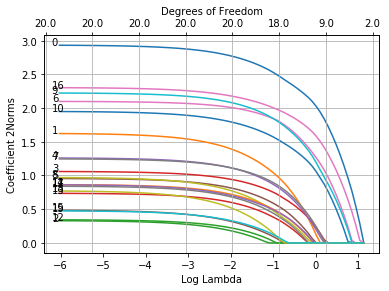

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.147689. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:
glmnetPlot(mfit, xvar = 'lambda', label = True, ptype = '2norm');

Note that we set `type.coef = "2norm"`. Under this setting, a single curve is plotted per variable, with value equal to the $\ell_2$ norm. The default setting is `type.coef = "coef"`, where a coefficient plot is created for each response (multiple figures).

`xvar` and `label` are two other options besides ordinary graphical parameters. They are the same as the single-response case.

We can extract the coefficients at requested values of $\lambda$ by using the function `coef` and make predictions by `predict`. The usage is similar and we only provide an example of `predict` here.

In [23]:
f = glmnetPredict(mfit, x[0:5,:], s = scipy.float64([0.1, 0.01]))
print(f[:,:,0], '\n')
print(f[:,:,1])

[[-4.71062632 -1.16345744  0.60276341  3.74098912]
 [ 4.13017346 -3.05079679 -1.21226299  4.97014084]
 [ 3.15952287 -0.57596208  0.2607981   2.05397555]
 [ 0.64592424  2.12056049 -0.22520497  3.14628582]
 [-1.17918903  0.10562619 -7.33529649  3.24836992]] 

[[-4.6415158  -1.22902821  0.61182888  3.77952124]
 [ 4.47128428 -3.25296583 -1.25725829  5.2660386 ]
 [ 3.47352281 -0.69292309  0.46840369  2.05557354]
 [ 0.73533106  2.29650827 -0.21902966  2.98937089]
 [-1.27599301  0.28925358 -7.82592058  3.20521075]]


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.436170. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The prediction result is saved in a three-dimensional array with the first two dimensions being the prediction matrix for each response variable and the third indicating the response variables.

We can also do k-fold cross-validation. The options are almost the same as the ordinary Gaussian family and we do not expand here.

In [24]:
warnings.filterwarnings('ignore')
cvmfit = cvglmnet(x = x.copy(), y = y.copy(), family = "mgaussian")
warnings.filterwarnings('default')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.445141. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We plot the resulting `cv.glmnet` object "cvmfit".

../lib/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


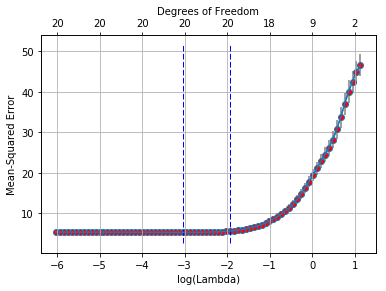

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.549014. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:
cvglmnetPlot(cvmfit)

To show explicitly the selected optimal values of $\lambda$, type

In [26]:
cvmfit['lambda_min']

array([ 0.04731812])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.840405. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [27]:
cvmfit['lambda_1se']

array([ 0.1445027])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.846017. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


As before, the first one is the value at which the minimal mean squared error is achieved and the second is for the most regularized model whose mean squared error is within one standard error of the minimal.

Prediction for `cvglmnet` object works almost the same as for `glmnet` object. We omit the details here.

[Back to <a href='#toc'>Table of Contents</a>]

<a id='logisticRegression'></a>
# Logistic Regression
Logistic regression  is another widely-used model when the response is categorical. If there are two possible outcomes, we use the binomial distribution, else we use the multinomial.

<a id='binomial'></a>
## Logistic Regression: Binomial Models
For the binomial model, suppose the response variable takes value in $\mathcal{G}=\{1,2\}$. Denote $y_i = I(g_i=1)$. We model
$$\mbox{Pr}(G=2|X=x)+\frac{e^{\beta_0+\beta^Tx}}{1+e^{\beta_0+\beta^Tx}},$$
which can be written in the following form
$$\log\frac{\mbox{Pr}(G=2|X=x)}{\mbox{Pr}(G=1|X=x)}=\beta_0+\beta^Tx,$$
the so-called "logistic" or log-odds transformation.

The objective function for the penalized logistic regression uses the negative binomial log-likelihood, and is
$$
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}} -\left[\frac{1}{N} \sum_{i=1}^N y_i \cdot (\beta_0 + x_i^T \beta) - \log (1+e^{(\beta_0+x_i^T \beta)})\right] + \lambda \big[ (1-\alpha)||\beta||_2^2/2 + \alpha||\beta||_1\big].
$$
Logistic regression is often plagued with degeneracies when $p > N$ and exhibits wild behavior even when $N$ is close to $p$;
the elastic-net penalty alleviates these issues, and regularizes and selects variables as well.

Our algorithm uses a quadratic approximation to the log-likelihood,  and then coordinate descent on the resulting penalized weighted least-squares problem. These constitute an outer and inner loop.


For illustration purpose, we load pre-generated input matrix `x` and the response vector `y` from the data file.

In [28]:
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'BinomialExampleX.dat', dtype = scipy.float64, delimiter = ',')
y = scipy.loadtxt(baseDataDir + 'BinomialExampleY.dat', dtype = scipy.float64)

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.853625. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The input matrix $x$ is the same as other families. For binomial logistic regression, the response variable $y$ should be either a factor with two levels, or a two-column matrix of counts or proportions.

Other optional arguments of `glmnet` for binomial regression are almost same as those for Gaussian family. Don't forget to set `family` option to "binomial".

In [29]:
fit = glmnet(x = x.copy(), y = y.copy(), family = 'binomial')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.924081. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Like before, we can print and plot the fitted object, extract the coefficients at specific $\lambda$'s and also make predictions. For plotting, the optional arguments such as `xvar` and `label` are similar to the Gaussian. We plot against the deviance explained and show the labels.

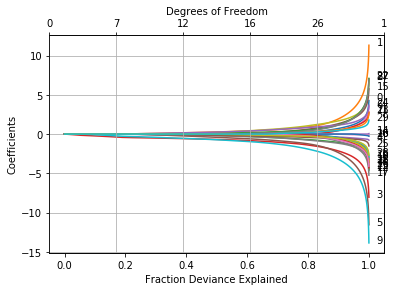

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:24.987654. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
glmnetPlot(fit, xvar = 'dev', label = True);

Prediction is a little different for logistic from Gaussian, mainly in the option `type`. "link" and "response" are never equivalent and "class" is only available for logistic regression. In summary,
* "link" gives the linear predictors

* "response" gives the fitted probabilities

* "class" produces the class label corresponding to the maximum probability.

* "coefficients" computes the coefficients at values of `s`

* "nonzero" retuns a list of the indices of the nonzero coefficients for each value of `s`.

For "binomial" models, results ("link", "response", "coefficients", "nonzero") are returned only for the class corresponding to the second level of the factor response.

In the following example, we make prediction of the class labels at $\lambda = 0.05, 0.01$.

In [31]:
glmnetPredict(fit, newx = x[0:5,], ptype='class', s = scipy.array([0.05, 0.01]))

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 0.,  0.],
       [ 1.,  1.]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.349613. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


For logistic regression, `cvglmnet` has similar arguments and usage as Gaussian. `nfolds`, `weights`, `lambda`, `parallel` are all available to users. There are some differences in `ptype`: "deviance" and "mse" do not both mean squared loss and "class" is enabled. Hence,
* "mse" uses squared loss.

* "deviance" uses actual deviance.

* "mae" uses mean absolute error.

* "class" gives misclassification error.

* "auc" (for two-class logistic regression ONLY) gives area under the ROC curve.

For example,

In [32]:
warnings.filterwarnings('ignore')
cvfit = cvglmnet(x = x.copy(), y = y.copy(), family = 'binomial', ptype = 'class')
warnings.filterwarnings('default')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.356949. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


It uses misclassification error as the criterion for 10-fold cross-validation.

We plot the object and show the optimal values of $\lambda$.

../lib/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


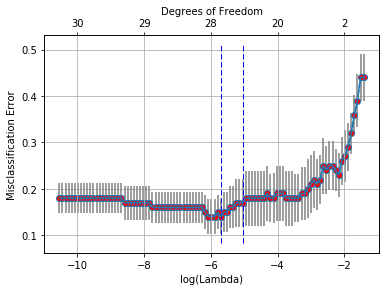

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.654004. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [33]:
cvglmnetPlot(cvfit)

In [34]:
cvfit['lambda_min']

array([ 0.00333032])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.854551. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [35]:
cvfit['lambda_1se']

array([ 0.00638726])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.860444. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


`coef` and `predict` are simliar to the Gaussian case and we omit the details. We review by some examples.

In [36]:
cvglmnetCoef(cvfit, s = 'lambda_min')

array([[ 0.1834094 ],
       [ 0.63979413],
       [ 1.75552224],
       [-1.01816297],
       [-2.04021446],
       [-0.3708456 ],
       [-2.17833787],
       [ 0.37214969],
       [-1.11649964],
       [ 1.59942098],
       [-3.00907083],
       [-0.3709413 ],
       [-0.50788757],
       [-0.54759695],
       [ 0.37853469],
       [ 0.        ],
       [ 1.22026778],
       [-0.00760482],
       [-0.8171956 ],
       [-0.4683986 ],
       [-0.44077522],
       [ 0.        ],
       [ 0.51053862],
       [ 1.06639664],
       [-0.57196411],
       [ 1.10470005],
       [-0.529917  ],
       [-0.67932357],
       [ 1.02441643],
       [-0.49368737],
       [ 0.41948873]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.867619. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


As mentioned previously, the results returned here are only for the second level of the factor response.

In [37]:
cvglmnetPredict(cvfit, newx = x[0:10, ], s = 'lambda_min', ptype = 'class')

array([[ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.876367. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Like other GLMs, glmnet allows for an "offset". This is a fixed vector of N numbers that is added into the linear predictor.
For example, you may have fitted some other logistic regression using other variables (and data), and now you want to see if the present variables can add anything. So you use the predicted logit from the other model as an offset in.

Like other GLMs, glmnet allows for an "offset". This is a fixed vector of N numbers that is added into the linear predictor.
For example, you may have fitted some other logistic regression using other variables (and data), and now you want to see if the present variables can add anything. So you use the predicted logit from the other model as an offset in.

[Back to <a href='#toc'>Table of Contents</a>]

<a id='multinomial'></a>
## Logistic Regression: Multinomial Models

For the multinomial model, suppose the response variable has $K$ levels ${\cal G}=\{1,2,\ldots,K\}$. Here we model
$$\mbox{Pr}(G=k|X=x)=\frac{e^{\beta_{0k}+\beta_k^Tx}}{\sum_{\ell=1}^Ke^{\beta_{0\ell}+\beta_\ell^Tx}}.$$

Let ${Y}$ be the $N \times K$ indicator response matrix, with elements $y_{i\ell} = I(g_i=\ell)$. Then the elastic-net penalized negative log-likelihood function becomes
$$
\ell(\{\beta_{0k},\beta_{k}\}_1^K) = -\left[\frac{1}{N} \sum_{i=1}^N \Big(\sum_{k=1}^Ky_{il} (\beta_{0k} + x_i^T \beta_k)- \log \big(\sum_{k=1}^K e^{\beta_{0k}+x_i^T \beta_k}\big)\Big)\right] +\lambda \left[ (1-\alpha)||\beta||_F^2/2 + \alpha\sum_{j=1}^p||\beta_j||_q\right].
$$
Here we really abuse notation! $\beta$ is a $p\times K$ matrix of coefficients. $\beta_k$ refers to the kth column (for outcome category k), and $\beta_j$ the jth row (vector of K coefficients for variable j).
The last penalty term is $||\beta_j||_q$, we have two options for q: $q\in \{1,2\}$.
When q=1, this is a lasso penalty on each of the parameters. When q=2, this is a grouped-lasso penalty on all the K coefficients for a particular variables, which makes them all be zero or nonzero together.

The standard Newton algorithm can be tedious here. Instead, we use a so-called partial Newton algorithm by making a partial quadratic approximation to the log-likelihood, allowing only $(\beta_{0k}, \beta_k)$ to vary for a single class at a time.
For each value of $\lambda$, we first cycle over all classes indexed by $k$, computing each time a partial quadratic approximation about the parameters of the current class. Then the inner procedure is almost the same as for the binomial case.
This is the case for lasso (q=1). When q=2, we use a different approach, which we wont dwell on here.

For the multinomial case, the usage is similar to logistic regression, and we mainly illustrate by examples and address any differences. We load a set of generated data.

In [38]:
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'MultinomialExampleX.dat', dtype = scipy.float64, delimiter = ',')
y = scipy.loadtxt(baseDataDir + 'MultinomialExampleY.dat', dtype = scipy.float64)

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.883797. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The optional arguments in `glmnet` for multinomial logistic regression are mostly similar to binomial regression except for a few cases.

The response variable can be a `nc >= 2` level factor, or a `nc`-column matrix of counts or proportions.
Internally glmnet will make the rows of this matrix sum to 1, and absorb the total mass into the weight for that observation.

`offset` should be a `nobs x nc` matrix if there is one.

A special option for multinomial regression is `mtype`, which allows the usage of a grouped lasso penalty if `mtype = 'grouped'`. This will ensure that the multinomial coefficients for a variable are all in or out together, just like for the multi-response Gaussian.

In [39]:
fit = glmnet(x = x.copy(), y = y.copy(), family = 'multinomial', mtype = 'grouped')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:25.969802. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We plot the resulting object "fit".

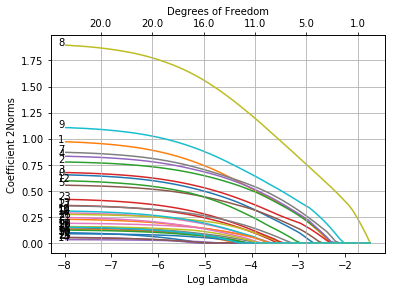

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:26.126834. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [40]:
glmnetPlot(fit, xvar = 'lambda', label = True, ptype = '2norm');

The options are `xvar`, `label` and `ptype`, in addition to other ordinary graphical parameters.

`xvar` and `label` are the same as other families while `ptype` is only for multinomial regression and multiresponse Gaussian model. It can produce a figure of coefficients for each response variable if `ptype = "coef"` or a figure showing the $\ell_2$-norm in one figure if `ptype = "2norm"`

We can also do cross-validation and plot the returned object.

../lib/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


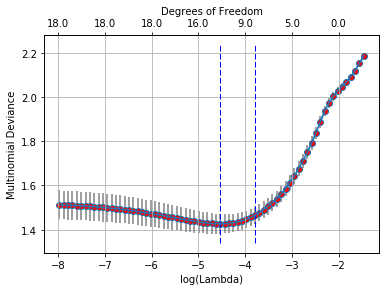

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:26.505389. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [41]:
warnings.filterwarnings('ignore')
cvfit=cvglmnet(x = x.copy(), y = y.copy(), family='multinomial', mtype = 'grouped');
warnings.filterwarnings('default')
cvglmnetPlot(cvfit)

Note that although `mtype` is not a typical argument in `cvglmnet`, in fact any argument that can be passed to `glmnet` is valid in the argument list of `cvglmnet`. We also use parallel computing to accelerate the calculation.

Users may wish to predict at the optimally selected $\lambda$:

In [42]:
cvglmnetPredict(cvfit, newx = x[0:10, :], s = 'lambda_min', ptype = 'class')

array([ 3.,  2.,  2.,  1.,  1.,  3.,  3.,  1.,  1.,  2.])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:27.724108. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


[Back to <a href='#toc'>Table of Contents</a>]

<a id='poisson'></a>
# Poisson Models

Poisson regression is used to model count data under the assumption of Poisson error, or otherwise non-negative data where the mean and variance are proportional. Like the Gaussian and binomial model, the Poisson is a member of the exponential family of distributions. We usually model its positive mean on the log scale:   $\log \mu(x) = \beta_0+\beta' x$.
The log-likelihood for observations $\{x_i,y_i\}_1^N$ is given my
$$
l(\beta|X, Y) = \sum_{i=1}^N (y_i (\beta_0+\beta' x_i) - e^{\beta_0+\beta^Tx_i}.
$$
As before, we optimize the penalized log-likelihood:
 $$
\min_{\beta_0,\beta} -\frac1N l(\beta|X, Y)  + \lambda \left((1-\alpha) \sum_{i=1}^N \beta_i^2/2) +\alpha \sum_{i=1}^N |\beta_i|\right).
$$

Glmnet uses an outer Newton loop, and an inner weighted least-squares loop (as in logistic regression) to optimize this criterion.

First, we load a pre-generated set of Poisson data.

In [43]:
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'PoissonExampleX.dat', dtype = scipy.float64, delimiter = ',')
y = scipy.loadtxt(baseDataDir + 'PoissonExampleY.dat', dtype = scipy.float64, delimiter = ',')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:27.734626. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We apply the function `glmnet` with the `"poisson"` option.

In [44]:
fit = glmnet(x = x.copy(), y = y.copy(), family = 'poisson')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:27.839106. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The optional input arguments of `glmnet` for `"poisson"` family are similar to those for others.

`offset` is a useful argument particularly in Poisson models.

When dealing with rate data in Poisson models, the counts collected are often based on different  exposures, such as length of time observed, area and years. A poisson rate $\mu(x)$ is relative to a unit exposure time, so if an observation $y_i$ was exposed for $E_i$ units of time, then the expected count would be $E_i\mu(x)$, and the log mean would be $\log(E_i)+\log(\mu(x)$. In a case like this, we would supply an *offset* $\log(E_i)$ for each observation.
Hence `offset` is a vector of length `nobs` that is included in the linear predictor.   Other families can also use options, typically for different reasons.

(Warning: if `offset` is supplied in `glmnet`, offsets must also also be supplied to `predict` to make reasonable predictions.)

Again, we plot the coefficients to have a first sense of the result.

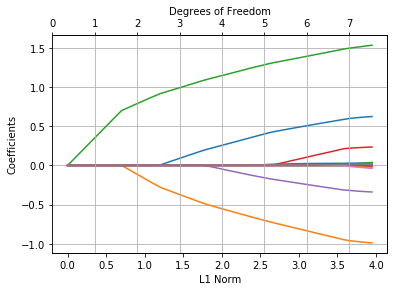

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:27.868641. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [45]:
glmnetPlot(fit);

Like before, we can extract the coefficients and make predictions at certain $\lambda$'s by using `coef` and `predict` respectively. The optional input arguments are similar to those for other families. In function `predict`, the option `type`, which is the type of prediction required, has its own specialties for Poisson family. That is,
* "link" (default) gives the linear predictors like others
* "response" gives the fitted mean
* "coefficients" computes the coefficients at the requested values for `s`, which can also be realized by `coef` function
* "nonzero" returns a a list of the indices of the nonzero coefficients for each value of `s`.

For example, we can do as follows:

In [46]:
glmnetCoef(fit, s = scipy.float64([1.0]))

array([[ 0.61123371],
       [ 0.45819758],
       [-0.77060709],
       [ 1.34015128],
       [ 0.043505  ],
       [-0.20325967],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.01816309],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:28.160072. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [47]:
glmnetPredict(fit, x[0:5,:], ptype = 'response', s = scipy.float64([0.1, 0.01]))

array([[  2.49442322,   2.54623385],
       [ 10.35131198,  10.33773624],
       [  0.11797039,   0.10639897],
       [  0.97134115,   0.92329512],
       [  1.11334721,   1.07256799]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:42:28.168296. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We may also use cross-validation to find the optimal $\lambda$'s and thus make inferences.

In [51]:
warnings.filterwarnings('ignore')
cvfit = cvglmnet(x=x.copy(), y=y.copy(), family = 'poisson')
warnings.filterwarnings('default')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:31.278345. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Options are almost the same as the Gaussian family except that for `type.measure`,
* "deviance" (default) gives the deviance
* "mse" stands for mean squared error
* "mae" is for mean absolute error.

We can plot the `cvglmnet` object.

../lib/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


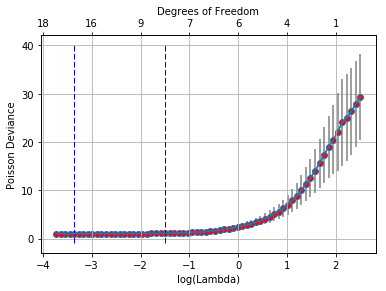

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:34.652662. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [52]:
cvglmnetPlot(cvfit)


We can also show the optimal $\lambda$'s and the corresponding coefficients.

In [53]:
optlam = scipy.array([cvfit['lambda_min'], cvfit['lambda_1se']]).reshape([2,])
cvglmnetCoef(cvfit, s = optlam)

array([[  2.72128916e-02,   1.85696196e-01],
       [  6.20006263e-01,   5.75373801e-01],
       [ -9.85744959e-01,  -9.32121975e-01],
       [  1.52693390e+00,   1.47056730e+00],
       [  2.32156777e-01,   1.96923579e-01],
       [ -3.37405607e-01,  -3.04694503e-01],
       [  1.22308275e-03,   0.00000000e+00],
       [ -1.35769399e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00],
       [  1.69722836e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00],
       [  3.10187944e-02,   2.58501705e-02],
       [ -2.92817638e-02,   0.00000000e+00],
       [  3.38822516e-02,   0.00000000e+00],
       [ -6.66067519e-03,   0.00000000e+00],
       [  1.83937264e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00],
       [  4.54888769e-03,   0.00000000e+00],
       [ -3.45423073e-02,   0.00000000e+00],
       [  1.20550886e-02,   9.92954798e-03]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:36.740617. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The `predict` method is similar and we do not repeat it here.

[Back to <a href='#toc'>Table of Contents</a>]

<a id='cox'></a>
# Cox Models

The Cox proportional hazards model is commonly used for the study of the relationship beteween predictor variables and survival time. In the usual survival analysis framework, we have data of the form $(y_1, x_1, \delta_1), \ldots, (y_n, x_n, \delta_n)$ where $y_i$, the observed time, is a time of failure if $\delta_i$ is 1 or right-censoring if $\delta_i$ is 0. We also let $t_1 < t_2 < \ldots < t_m$ be the increasing list of unique failure times, and $j(i)$ denote the index of the observation failing at time $t_i$.

The Cox model assumes a semi-parametric form for the hazard
$$
h_i(t) = h_0(t) e^{x_i^T \beta},
$$
where $h_i(t)$ is the hazard for patient $i$ at time $t$, $h_0(t)$ is a shared baseline hazard, and $\beta$ is a fixed, length $p$ vector. In the classic setting $n \geq p$, inference is made via the partial likelihood
$$
L(\beta) = \prod_{i=1}^m \frac{e^{x_{j(i)}^T \beta}}{\sum_{j \in R_i} e^{x_j^T \beta}},
$$
where $R_i$ is the set of indices $j$ with $y_j \geq t_i$ (those at risk at time $t_i$).

Note there is no intercept in the Cox mode (its built into the baseline hazard, and like it, would cancel in the partial likelihood.)

We penalize the negative log of the partial likelihood, just like the other models, with an elastic-net penalty.

We use a pre-generated set of sample data and response. Users can load their own data and follow a similar procedure. In this case $x$ must be an $n\times p$ matrix of covariate values — each row corresponds to a patient and each column a covariate. $y$ is an $n \times 2$  matrix, with a column "time" of failure/censoring times, and "status" a 0/1 indicator, with 1 meaning the time is a failure time, and zero a censoring time.

In [54]:
# Import relevant modules and setup for calling glmnet
%reset -f
%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'CoxExampleX.dat', dtype = scipy.float64, delimiter = ',')
y = scipy.loadtxt(baseDataDir + 'CoxExampleY.dat', dtype = scipy.float64, delimiter = ',')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:40.124142. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The `Surv` function in the package `survival` can create such a matrix. Note, however, that the `coxph` and related linear models can handle interval and other fors of censoring, while glmnet can only handle right censoring in its present form.

We apply the `glmnet` function to compute the solution path under default settings.

In [55]:
fit = glmnet(x = x.copy(), y = y.copy(), family = 'cox')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:42.731917. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


All the standard options are available such as `alpha`, `weights`, `nlambda` and `standardize`. Their usage is similar as in the Gaussian case and we omit the details here. Users can also refer to the help file `help(glmnet)`.

We can plot the coefficients.

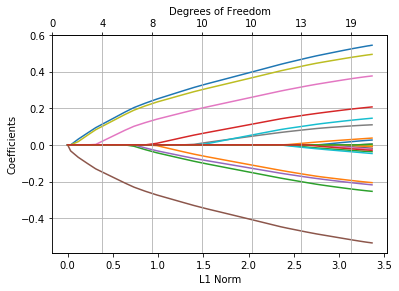

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:43.932028. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [56]:
glmnetPlot(fit);

As before, we can extract the coefficients at certain values of $\lambda$.

In [57]:
glmnetCoef(fit, s = scipy.float64([0.05]))

array([[ 0.37693638],
       [-0.09547797],
       [-0.13595972],
       [ 0.09814146],
       [-0.11437545],
       [-0.38898545],
       [ 0.242914  ],
       [ 0.03647596],
       [ 0.34739813],
       [ 0.03865115],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-21 18:43:45.372576. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Since the Cox Model is not commonly used for prediction, we do not give an illustrative example on prediction. If needed, users can refer to the help file by typing `help(predict.glmnet)`.

Currently, cross-validation is not implemented for cox case. But this is not difficult to do using the existing `glmnet` calls that work perfectly well for this case. (TBD: `cvglmnet` to be implemented for cox).

[Back to <a href='#toc'>Table of Contents</a>]

<a id='references'></a>
## References


<p>Jerome Friedman, Trevor Hastie and Rob Tibshirani. (2008). <br>
<a href="http://www.jstatsoft.org/v33/i01/">Regularization Paths for Generalized Linear Models via Coordinate Descent</a><br>
<em>Journal of Statistical Software</em>, Vol. 33(1), 1-22 Feb 2010.</p>
<p>Noah Simon, Jerome Friedman, Trevor Hastie and Rob Tibshirani. (2011).<br>
<a href="http://www.jstatsoft.org/v39/i05/">Regularization Paths for Cox's Proportional Hazards Model via Coordinate Descent</a><br>
<em>Journal of Statistical Software</em>, Vol. 39(5) 1-13.</p>
<p>Robert Tibshirani, Jacob Bien, Jerome Friedman, Trevor Hastie, Noah Simon, Jonathan Taylor, Ryan J. Tibshirani. (2010).<br>
<a href="http://www-stat.stanford.edu/~tibs/ftp/strong.pdf">Strong Rules for Discarding Predictors in Lasso-type Problems</a><br>
<em>Journal of the Royal Statistical Society: Series B (Statistical Methodology)</em>, 74(2), 245-266.</p>
<p> Noah Simon, Jerome Friedman and Trevor Hastie (2013). <br>
<a href="http://www.stanford.edu/~hastie/Papers/multi_response.pdf">A Blockwise Descent Algorithm for Group-penalized Multiresponse and Multinomial Regression </a><br>